In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LassoLarsCV
import pickle

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [293]:
sns.set(rc={'figure.figsize':(20,10)})

In [406]:
with open('../scraping/stats_salaries_cap.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [4]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_squared_log_error
def evaluate(y_pred, y_test):
    """ Prints out the evaluation metrics of the experiment
        parameters:
            y_pred
                DataFrame or array-like, the predictions
            y_test
                DataFrame or array-like, the actual y-values
                
            these two parameters must have the same dimensions
    """
    print("r^2: ", r2_score(y_test, y_pred))
    print("mse: ", mean_squared_error(y_test, y_pred))
    print("variance_score: ", explained_variance_score(y_test, y_pred))

In [204]:
data = data[(data['cap_usage'] >= 0.023) & (data['GP'] >= 20)]

In [368]:
seed = 77

<AxesSubplot:xlabel='salary_category', ylabel='count'>

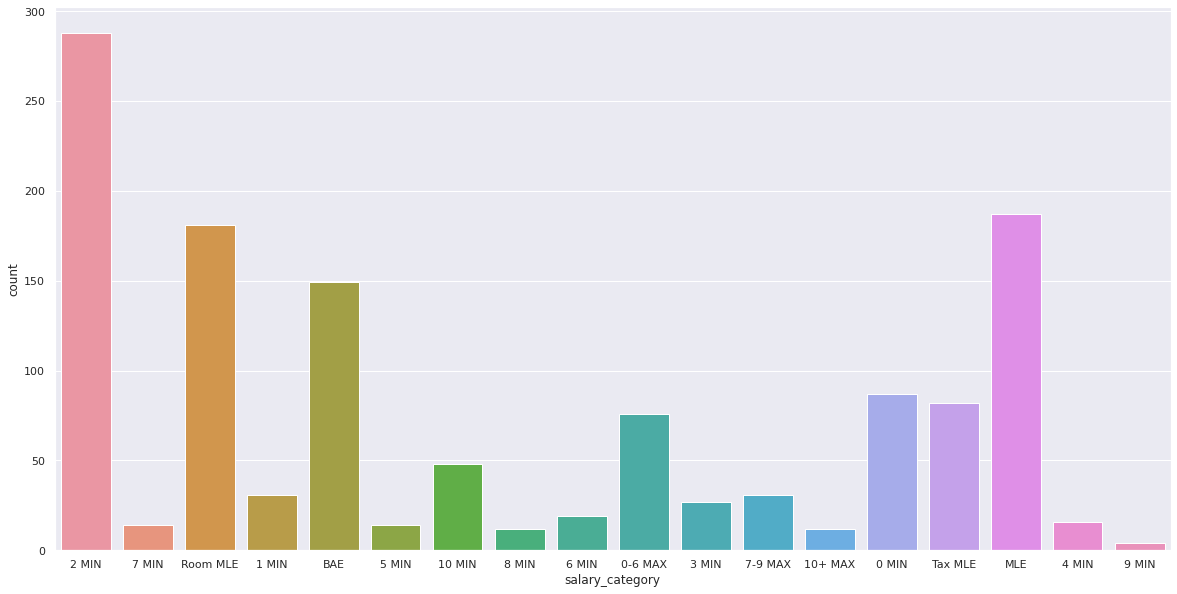

In [412]:
sns.countplot(x='salary_category', data=data)

# Manual sampling for balanced salary categories

In [420]:
X = data.drop(columns=['Player', 'previous season', 'Next season', 'Salary',
       'salary_cap', 'cap_usage', 'salary_category', 'season_x', 'season_y'])
X = pd.concat([X.drop('Pos', axis=1), pd.get_dummies(X.Pos)], axis=1)

y = data['cap_usage']

In [421]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)

<AxesSubplot:xlabel='cap_usage'>

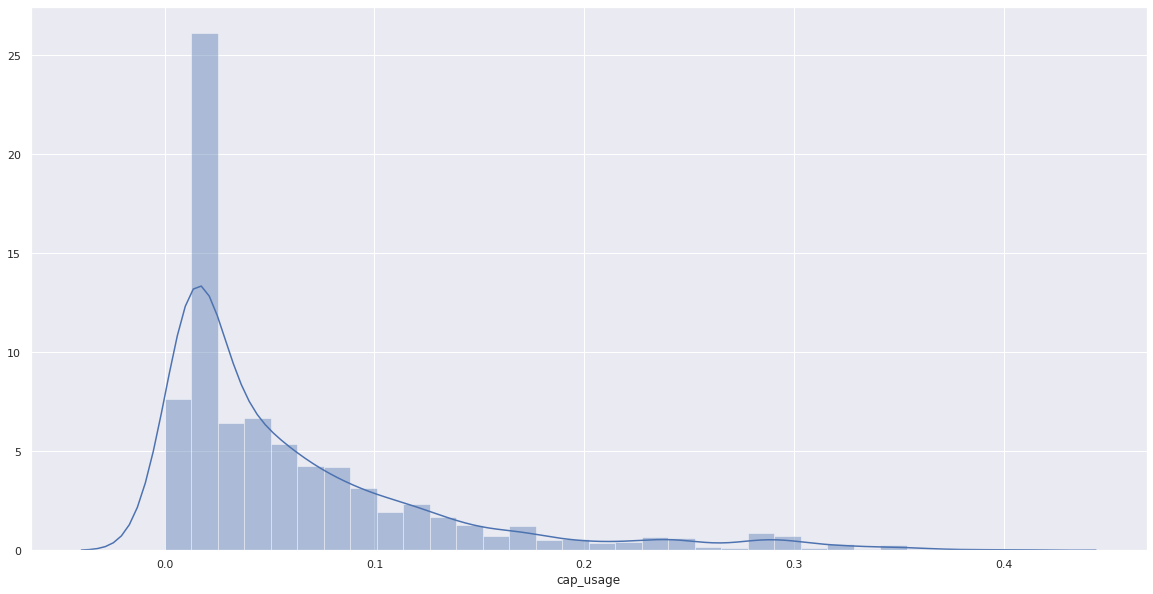

In [422]:
sns.distplot(y)

<AxesSubplot:xlabel='cap_usage'>

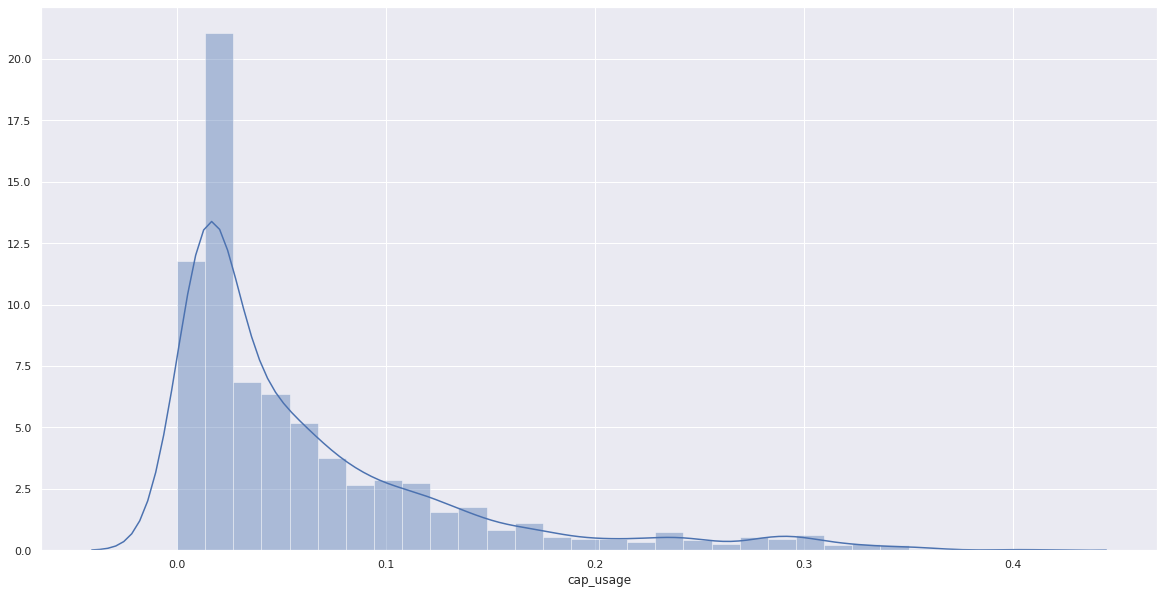

In [423]:
sns.distplot(y_train)

# Feature Selection

In [424]:
select = SelectKBest(f_regression, k=90)

In [425]:
best_features = select.fit_transform(X, y)
feature_scores = pd.concat([pd.Series(X.columns), pd.Series(select.scores_)], axis=1)
feature_scores.columns = ["features", "score"]
features = list(feature_scores.sort_values(by=["score"], ascending=False).head(25)['features'])

In [429]:
X_train = X_train[features]
X_test = X_test[features]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=seed)

In [430]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [431]:
evaluate(lr.predict(X_val), y_val)

r^2:  0.6844437646091441
mse:  0.0012887658482176952
variance_score:  0.6863179726951399


In [432]:
evaluate(lr.predict(X_test), y_test)

r^2:  0.6467679571615247
mse:  0.0017472021975884783
variance_score:  0.6487460083633636


In [433]:
ridge_cv = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=5)
ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([0.001, 0.01 , 0.1  , 1.   ]), cv=5)

In [434]:
evaluate(ridge_cv.predict(X_val), y_val)

r^2:  0.6790255585962182
mse:  0.0013108943885059817
variance_score:  0.681038900736096


In [435]:
evaluate(ridge_cv.predict(X_test), y_test)

r^2:  0.657410969583872
mse:  0.0016945583475462837
variance_score:  0.65912070915047


# NN

In [114]:
from sklearn.neural_network import MLPRegressor

In [43]:
mlp_dict = {
    'hidden_layer_sizes': (5000, 2500, 1000, 500),
    'max_iter': 5000,
}

mlp_toy = MLPRegressor(**mlp_dict)
mlp_toy.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(5000, 2500, 1000, 500), max_iter=5000)

In [44]:
mean_squared_error(y_val, mlp_toy.predict(X_val))

0.012962447223037889

# GBDT

In [167]:
from sklearn.ensemble import GradientBoostingRegressor

In [397]:
params = {'n_estimators': 1000,
 'min_samples_split': 8,
 'min_samples_leaf': 8,
 'max_depth': None,
 'learning_rate': 0.03,
 'alpha': 0.6,
 'loss': 'quantile'}

gbdt_toy = GradientBoostingRegressor(**params)
gbdt_toy.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.6, learning_rate=0.03, loss='quantile',
                          max_depth=None, min_samples_leaf=8,
                          min_samples_split=8, n_estimators=1000)

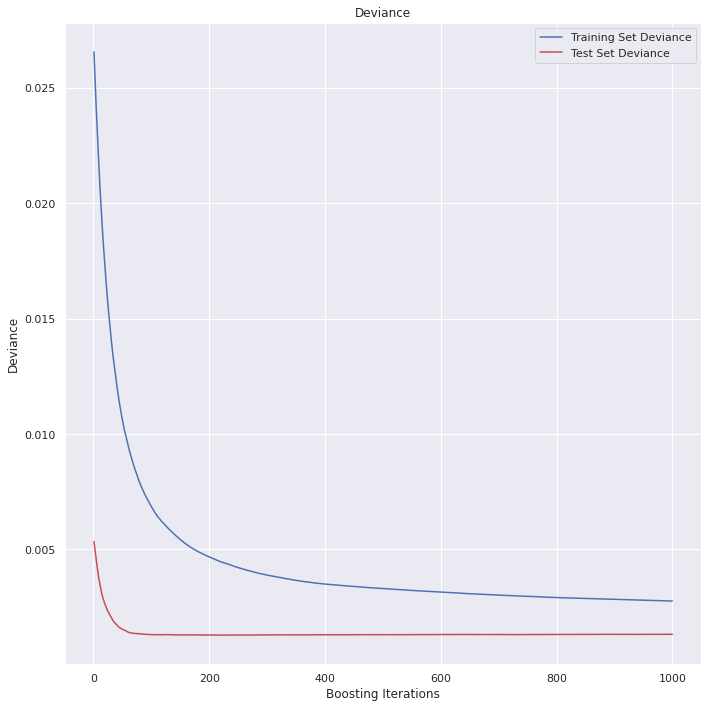

In [398]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(gbdt_toy.staged_predict(X_val)):
    test_score[i] = mean_squared_error(y_val, y_pred)

fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, gbdt_toy.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

In [399]:
evaluate(gbdt_toy.predict(X_val), y_val)

r^2:  0.7596462231094115
mse:  0.0013258565109200825
variance_score:  0.7601219919945388


In [400]:
evaluate(gbdt_toy.predict(X_test), y_test)

r^2:  0.5900863411721601
mse:  0.0018582158457382057
variance_score:  0.5917172912229742


In [401]:
tmp = data.loc[y_test.index][['Player', 'previous season', 'cap_usage', 'salary_cap',  'Salary']]
tmp['pred_cap_usage'] = gbdt_toy.predict(X_test)
tmp['pred_salary'] = tmp['pred_cap_usage'] * tmp['salary_cap']
tmp['pred_salary'] = tmp['pred_salary'].apply(int)
tmp = tmp[['Player', 'previous season', 'salary_cap', 'cap_usage', 'pred_cap_usage', 'Salary', 'pred_salary']]

In [405]:
tmp.iloc[100:150]

,Player,previous season,salary_cap,cap_usage,pred_cap_usage,Salary,pred_salary
170,Marvin Williams,2006-07,55630000,0.080281,0.054331,4466040.0,3022451
925,Gerald Green,2015-16,94143000,0.014984,0.049735,1410598.0,4682180
270,Adonal Foyle,2008-09,57700000,0.022642,0.016813,1306455.0,970125
171,Shelden Williams,2006-07,55630000,0.057060,0.041159,3174240.0,2289671
359,Joey Graham,2009-10,58044000,0.017102,0.027813,992680.0,1614386
608,Jason Collins,2012-13,58679000,0.007436,0.023286,436316.0,1366389
187,Earl Boykins,2006-07,55630000,0.009591,0.066605,533572.0,3705260
1057,Mario Hezonja,2017-18,101869000,0.063807,0.063845,6500000.0,6503829
689,Bernard James,2013-14,63065000,0.019976,0.017951,1259775.0,1132075
72,Zydrunas Ilgauskas,2004-05,49500000,0.176566,0.241610,8740000.0,11959691


# XG Boost

In [238]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

In [240]:
cpu_dict = {
    'objective': 'reg:squarederror', 
    'n_estimators': 3000,
    'max_depth': None,
    'colsample_bytree': 0.97
}
xgb_toy = XGBRegressor(**cpu_dict)

In [241]:
xgb_toy.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.97, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=3000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [242]:
r2_score(y_val, xgb_toy.predict(X_val))

0.5485139202488465

In [243]:
r2_score(y_test, xgb_toy.predict(X_test))

0.46478509245437205

In [247]:
# Number of trees in tree
n_estimators = range(500, 2500, 1000)

# Maximum number of levels in tree
max_depth = range(4, 6)

min_child_weight = range(1, 7)

# Create the random grid
random_grid = {'max_depth': max_depth,
               'min_child_weight': min_child_weight}

In [248]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgb = XGBRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 5, cv = 5, verbose=3, random_state=seed, n_jobs = -1)
# Fit the random search model
xgb_random.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, reg_alpha=None,
                                       

In [254]:
xgb_random.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [249]:
r2_score(y_val, xgb_random.predict(X_val))

0.5492806972019164

In [250]:
r2_score(y_test, xgb_random.predict(X_test))

0.54448144177171

# Light GBM

In [255]:
import lightgbm as lgb

In [436]:
lgb_toy = lgb.LGBMRegressor(boosting_type = 'dart', 
                            n_estimators=250)

In [437]:
lgb_toy.fit(X_train, y_train)

LGBMRegressor(boosting_type='dart', n_estimators=250)

In [438]:
r2_score(y_val, lgb_toy.predict(X_val))

0.7216275664145292

In [439]:
r2_score(y_test, lgb_toy.predict(X_test))

0.6739627482368973

In [447]:
boosting_type = ['gbdt', 'dart', 'goss', 'rf']

num_leaves = range(1, 30, 2)

min_child_weight = range(1, 100, 20)

lightgbm_grid = {'boosting_type': boosting_type,
                 'num_leaves': num_leaves,
                 'min_child_weight': min_child_weight}

In [448]:
lightgbm = lgb.LGBMRegressor(n_estimators = 2000)

lightgbm_random = RandomizedSearchCV(estimator = lightgbm,
                                     param_distributions = lightgbm_grid,
                                     n_iter = 30, cv = 5, verbose=3,
                                     random_state=seed, n_jobs = -1)
# Fit the random search model
lightgbm_random.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(n_estimators=2000), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss', 'rf'],
                                        'min_child_weight': range(1, 100, 20),
                                        'num_leaves': range(1, 30, 2)},
                   random_state=77, verbose=3)

In [449]:
r2_score(y_val, lightgbm_random.predict(X_val))

0.6748275852104857

In [450]:
r2_score(y_test, lightgbm_random.predict(X_test))

0.6248615128183723

In [451]:
lightgbm_random.best_estimator_

LGBMRegressor(boosting_type='dart', min_child_weight=21, n_estimators=2000,
              num_leaves=7)

In [452]:
tmp = data.loc[y_test.index][['Player', 'previous season', 'cap_usage', 'salary_cap',  'Salary']]
tmp['pred_cap_usage'] = lightgbm_random.predict(X_test)
tmp['pred_salary'] = tmp['pred_cap_usage'] * tmp['salary_cap']
tmp['pred_salary'] = tmp['pred_salary'].apply(int)
tmp = tmp[['Player', 'previous season', 'salary_cap', 'cap_usage', 'pred_cap_usage', 'Salary', 'pred_salary']]

In [453]:
tmp[100:150]

,Player,previous season,salary_cap,cap_usage,pred_cap_usage,Salary,pred_salary
609,Danny Granger,2013-14,63065000,0.032934,0.045657,2077000.0,2879387
123,Andray Blatche,2006-07,55630000,0.044568,0.015656,2479339.0,870930
906,Jonathan Gibson,2016-17,99093000,0.000449,0.007042,44495.0,697826
910,KJ McDaniels,2016-17,99093000,0.014848,0.022230,1471382.0,2202820
746,Lorenzo Brown,2014-15,70000000,0.001592,0.015435,111444.0,1080472
1017,Will Barton,2017-18,101869000,0.116133,0.157222,11830358.0,16015998
1029,Brandon Goodwin,2018-19,109140000,0.004790,0.014129,522738.0,1542042
1209,Bryn Forbes,2020-21,125000000,0.036000,0.066132,4500000.0,8266480
161,Linton Johnson,2006-07,55630000,0.000081,0.039999,4533.0,2225161
121,Willie Green,2005-06,53135000,0.052696,0.009056,2800000.0,481180
